# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gymnasium as gym
from gymnasium import spaces
import datetime
import my_library as mylib
# import importlib
# importlib.reload(my_library)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None

# Data manipulation

In [11]:
tickers = ['PFE','OXY','JPM','MCD'] # Pfizer, Occidental Petroleum, JPMorgan Chase, McDonald's
# tickers1 = ['PFE ','OXY ','JPM ','MCD '] 
tickers_vol = [ticker+'_VOL' for ticker in tickers]
data = pd.read_csv('others.csv', sep=',')
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
adj_close = data[tickers[0]]
df = pd.DataFrame({'Date': data['Date'], 'log_ret': np.log(adj_close/adj_close.shift(1)).dropna(), tickers_vol[0]: data[tickers_vol[0]]}).dropna().set_index('Date')
sp500 = pd.read_csv('sp500_joined_closes (3).csv', sep=',').dropna(axis=1)
data.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500.columns = new_cols
sp500.drop(tickers[0], axis=1, inplace=True)
sp500.drop(tickers_vol[0], axis=1, inplace=True)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')
col_stocks = [col for col in sp500.columns if not col.endswith('VOL')]
col_vols = [col for col in sp500.columns if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [12]:
sp500_lr = np.log(sp500[col_stocks]/sp500[col_stocks].shift(1))
sp500_lr = sp500_lr.drop(sp500_lr.index[0])
sp500_lr = sp500_lr.drop([col for col in sp500_lr.columns if sp500_lr[col].count() < 3633], axis=1)
df = df.join(sp500[col_vols],how='inner').dropna()
df = df.join(sp500_lr,how='inner').dropna()
df.describe()

log_ret       PFE_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  3638.000000  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean      0.000268  3.329464e+07  3.672072e+06  1.363582e+06  8.361895e+06   
std       0.013686  2.034679e+07  2.911937e+06  1.103023e+06  5.976096e+06   
min      -0.080501  5.187683e+06  7.785960e+05  2.042000e+05  1.067700e+06   
25%      -0.006490  2.104785e+07  2.380937e+06  8.305000e+05  4.614210e+06   
50%       0.000000  2.765886e+07  3.098058e+06  1.113950e+06  6.282250e+06   
75%       0.007045  3.882741e+07  4.108499e+06  1.586875e+06  1.024750e+07   
max       0.103054  2.998294e+08  6.043675e+07  3.248830e+07  7.810838e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean   2.772958e+06  3.756350e+06  4.659924e+07  5.907124e+06  4.438843e+06   
std    2.315021e+06  3.470823e+06  3.549588e+07  2.840392e+06  2.835895e+06   
min    5.281000e+05  5.892000e+05  0.000000e+00  9.862000e+05  8.789000e+05   
25%    1.813925e+06  2.136200e+06  1.889980e+07  4.110050e+06  2.677625e+06   
50%    2.333400e+06  2.906300e+06  3.877410e+07  5.336600e+06  3.640550e+06   
75%    3.150400e+06  4.277000e+06  6.321760e+07  7.026075e+06  5.307400e+06   
max    8.965590e+07  1.087524e+08  3.250584e+08  4.606760e+07  3.669320e+07   

       ...          WST          WDC           WY          WMB          WTW  \
count  ...  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean   ...     0.000799     0.000218     0.000296     0.000441     0.000433   
std    ...     0.017123     0.027057     0.019391     0.024196     0.014200   
min    ...    -0.151802    -0.228719    -0.257132    -0.427912    -0.113525   
25%    ...    -0.007562    -0.013190    -0.009073    -0.009434    -0.005715   
50%    ...     0.000930     0.000462     0.000681     0.000740     0.000695   
75%    ...     0.009358     0.014244     0.009957     0.010422     0.007123   
max    ...     0.135745     0.190144     0.225664     0.295550     0.140681   

              WYNN          XEL          YUM         ZBRA          ZBH  
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000  
mean      0.000211     0.000391     0.000539     0.000641     0.000194  
std       0.028792     0.012314     0.015034     0.022864     0.016214  
min      -0.280172    -0.135726    -0.208654    -0.272411    -0.150757  
25%      -0.013317    -0.005615    -0.006247    -0.009777    -0.007351  
50%      -0.000104     0.000632     0.000839     0.000930     0.000163  
75%       0.013625     0.007141     0.007597     0.011237     0.008326  
max       0.244422     0.106679     0.209032     0.158833     0.144790  

[8 rows x 860 columns]

Performing PCA on AAPL and SP500 stocks

In [13]:
cum_var_exp, PCs, regr_PCs, eig_vecs = mylib.PCA(df['log_ret'], sp500_lr, plot=False)

In [14]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     228.9
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:29:28   Log-Likelihood:                 11340.
No. Observations:                3638   AIC:                        -2.266e+04
Df Residuals:                    3627   BIC:                        -2.259e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.465e-05      0.000     -0.306      0.760      -0.000       0.000
PC0            0.0365      0.001     38.200      0.000       0.035       0.038
PC1           -0.0354      0.003    -13.316      0.000      -0.041      -0.030
PC2            0.0112      0.002      4.602      0.000       0.006       0.016
PC3           -0.0597      0.004    -16.012      0.000      -0.067      -0.052
PC4            0.0065      0.004      1.845      0.065      -0.000       0.013
PC5            0.0424      0.004      9.580      0.000       0.034       0.051
PC6           -0.0003      0.005     -0.059      0.953      -0.010       0.009
PC7            0.0155      0.005      3.284      0.001       0.006       0.025
PC8            0.0418      0.005      7.754      0.000       0.031       0.052
PC9           -0.0418      0.005     -7.632      0.000      -0.052      -0.031
==============================================================================
Omnibus:                      649.188   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12710.850
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                      12.143   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
PCs.columns = PCs.columns.str.replace('AAPL', tickers[0])

In [23]:
Y = PCs[tickers[0]]

In [24]:
[i-1 for i,p in enumerate(regr_PCs.tvalues) if abs(p) > 1.96]

[0, 1, 2, 3, 5, 7, 8, 9]

In [25]:
t_vals = regr_PCs.tvalues.drop('const')

In [26]:
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)

['PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC7', 'PC8', 'PC9']

In [27]:
X = PCs[list(t_vals.index)]
X

PC0       PC1       PC2       PC3       PC4       PC5  \
Date                                                                     
2010-01-05  0.078282  0.105813 -0.077699  0.036930  0.053891  0.000261   
2010-01-06  0.045489  0.025397 -0.033660 -0.021428 -0.052222 -0.018739   
2010-01-07  0.119079  0.057367 -0.075398  0.034323  0.133904  0.015612   
2010-01-08  0.056224  0.054642  0.034505 -0.026619 -0.064205 -0.061387   
2010-01-11  0.058569 -0.042048 -0.016444  0.006458 -0.000666  0.001460   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.114485  0.109913  0.075628  0.102582  0.032729 -0.051821   
2024-06-13 -0.053112 -0.051415  0.026619  0.027854  0.036048 -0.002882   
2024-06-14 -0.127096 -0.086347  0.063154  0.001414  0.009095  0.061859   
2024-06-17  0.147930  0.081176  0.008408 -0.036904  0.055066 -0.047854   
2024-06-18  0.057618  0.021405 -0.016182 -0.021416 -0.011237 -0.010093   

                 PC7       PC8       PC9  
Date                                      
2010-01-05 -0.021715  0.070892 -0.010688  
2010-01-06  0.059626 -0.044605  0.012044  
2010-01-07  0.049837 -0.025438 -0.018518  
2010-01-08 -0.005461 -0.044511 -0.010467  
2010-01-11  0.010610 -0.011815 -0.060527  
...              ...       ...       ...  
2024-06-12  0.017434 -0.005782 -0.012347  
2024-06-13 -0.005172  0.000837  0.015417  
2024-06-14 -0.005857  0.011844  0.070591  
2024-06-17 -0.068747 -0.026107  0.054463  
2024-06-18 -0.023741  0.026157  0.013159  

[3638 rows x 9 columns]

In [28]:
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    PFE   R-squared (uncentered):                   0.387
Model:                            OLS   Adj. R-squared (uncentered):              0.386
Method:                 Least Squares   F-statistic:                              254.7
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        18:33:05   Log-Likelihood:                          11340.
No. Observations:                3638   AIC:                                 -2.266e+04
Df Residuals:                    3629   BIC:                                 -2.261e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0364      0.001     38.342      0.000       0.035       0.038
PC1           -0.0354      0.003    -13.332      0.000      -0.041      -0.030
PC2            0.0112      0.002      4.626      0.000       0.006       0.016
PC3           -0.0598      0.004    -16.352      0.000      -0.067      -0.053
PC4            0.0065      0.004      1.859      0.063      -0.000       0.013
PC5            0.0424      0.004      9.590      0.000       0.034       0.051
PC7            0.0155      0.005      3.293      0.001       0.006       0.025
PC8            0.0419      0.005      7.820      0.000       0.031       0.052
PC9           -0.0418      0.005     -7.687      0.000      -0.052      -0.031
==============================================================================
Omnibus:                      649.030   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12706.234
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                      12.142   Cond. No.                         7.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
t_vals = regr_PCs.tvalues
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
X = sm.add_constant(X)
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PFE   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     285.5
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:33:10   Log-Likelihood:                 11339.
No. Observations:                3638   AIC:                        -2.266e+04
Df Residuals:                    3629   BIC:                        -2.260e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.944e-05      0.000     -0.277      0.782      -0.000       0.000
PC0            0.0362      0.001     38.416      0.000       0.034       0.038
PC1           -0.0364      0.003    -13.970      0.000      -0.042      -0.031
PC2            0.0112      0.002      4.625      0.000       0.006       0.016
PC3           -0.0590      0.004    -16.240      0.000      -0.066      -0.052
PC5            0.0417      0.004      9.465      0.000       0.033       0.050
PC7            0.0148      0.005      3.162      0.002       0.006       0.024
PC8            0.0412      0.005      7.699      0.000       0.031       0.052
PC9           -0.0440      0.005     -8.293      0.000      -0.054      -0.034
==============================================================================
Omnibus:                      650.085   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12757.982
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      12.160   Cond. No.                         31.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

True

In [31]:
t_vals = regr_PCs.tvalues
t_vals = regr_PCs.tvalues.drop('const')
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

False

In [32]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    PFE   R-squared (uncentered):                   0.385
Model:                            OLS   Adj. R-squared (uncentered):              0.384
Method:                 Least Squares   F-statistic:                              324.5
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        18:33:36   Log-Likelihood:                          11334.
No. Observations:                3638   AIC:                                 -2.265e+04
Df Residuals:                    3631   BIC:                                 -2.261e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0366      0.001     39.376      0.000       0.035       0.038
PC1           -0.0379      0.003    -14.793      0.000      -0.043      -0.033
PC2            0.0106      0.002      4.375      0.000       0.006       0.015
PC3           -0.0608      0.004    -16.892      0.000      -0.068      -0.054
PC5            0.0417      0.004      9.450      0.000       0.033       0.050
PC8            0.0399      0.005      7.477      0.000       0.029       0.050
PC9           -0.0429      0.005     -8.106      0.000      -0.053      -0.033
==============================================================================
Omnibus:                      636.891   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11872.792
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                      11.836   Cond. No.                         7.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Add the relevant PCs to the df

In [33]:
PCs[tickers[0]]

Date
2010-01-05   -0.014365
2010-01-06   -0.003221
2010-01-07   -0.003771
2010-01-08    0.008062
2010-01-11    0.007998
                ...   
2024-06-12   -0.013288
2024-06-13   -0.000362
2024-06-14   -0.004349
2024-06-17   -0.020181
2024-06-18    0.015812
Name: PFE, Length: 3638, dtype: float64

In [34]:
dataframe = pd.DataFrame(PCs[list(t_vals.index)])
dataframe['log_ret'] = df['log_ret']
dataframe

PC0       PC1       PC2       PC3       PC5       PC8  \
Date                                                                     
2010-01-05  0.078282  0.105813 -0.077699  0.036930  0.000261  0.070892   
2010-01-06  0.045489  0.025397 -0.033660 -0.021428 -0.018739 -0.044605   
2010-01-07  0.119079  0.057367 -0.075398  0.034323  0.015612 -0.025438   
2010-01-08  0.056224  0.054642  0.034505 -0.026619 -0.061387 -0.044511   
2010-01-11  0.058569 -0.042048 -0.016444  0.006458  0.001460 -0.011815   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.114485  0.109913  0.075628  0.102582 -0.051821 -0.005782   
2024-06-13 -0.053112 -0.051415  0.026619  0.027854 -0.002882  0.000837   
2024-06-14 -0.127096 -0.086347  0.063154  0.001414  0.061859  0.011844   
2024-06-17  0.147930  0.081176  0.008408 -0.036904 -0.047854 -0.026107   
2024-06-18  0.057618  0.021405 -0.016182 -0.021416 -0.010093  0.026157   

                 PC9   log_ret  
Date                            
2010-01-05 -0.010688 -0.014365  
2010-01-06  0.012044 -0.003221  
2010-01-07 -0.018518 -0.003771  
2010-01-08 -0.010467  0.008062  
2010-01-11 -0.060527  0.007998  
...              ...       ...  
2024-06-12 -0.012347 -0.013288  
2024-06-13  0.015417 -0.000362  
2024-06-14  0.070591 -0.004349  
2024-06-17  0.054463 -0.020181  
2024-06-18  0.013159  0.015812  

[3638 rows x 8 columns]

# Create the environment and agent, training, and backtesting

## Define the environment and agent

In [35]:
class TradingEnv(gym.Env):
    def __init__(self, df, rf):
        super(TradingEnv, self).__init__()

        self.current_step = 0
        self.data = df.iloc[:,df.columns != 'log_ret']
        self.y = df['log_ret']
        self.initial_position = pd.DataFrame({'0': [0], '1': [1]}) # Initial position is 1000 in risk_free asset
        self.position = self.initial_position.copy()
        self.initial_portfolio_value = list([1000])
        self.money = pd.DataFrame(self.initial_portfolio_value[0] * self.position)
        self.rf = rf
        self.pos_sup = 2
        self.pos_inf = -1
        # Define action and observation space
        
        # Only one stock, the rest is in cash
        self.action_space = np.arange(self.pos_inf, self.pos_sup, 0.15).round(2)
        # If two stocks, then self.action_space = spaces.Box(low=np.array([0,0]), high=np.array([1,1]), dtype=np.float32)
        
        # observation_space is a dataframe with historical data
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,df.shape[1]+5), dtype=np.float32)
           
    def step(self, state, action):
        # Execute one time step within the environment
        self.current_step += 1
        self.flag = 0

        # End the episode if we've run out of data
        if self.current_step >= days_train:
            return self.position, 0, True

        # Take the action (<0: short stock, ==0: hold positions, >0: buy stock)
        # action = action[0][0]
        if (action > self.pos_sup) or (action < self.pos_inf):
            reward = - 1000
            self.flag = 1
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
            self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
            pv = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
            new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
            self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)
            observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))
            return new_row_pos, reward, True
        new_port_value = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
        self.portfolio_value.append(new_port_value)
        
        if abs(action - self.position.iloc[self.current_step-1,0]) >= tol:
            new_row_pos = pd.DataFrame([[action, (1 - action)]])
        else:
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
        self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
        new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
        self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)

        if self.flag == 0:
            reward = (self.portfolio_value[self.current_step] - self.portfolio_value[self.current_step-1])/self.portfolio_value[self.current_step-1]
        
        done = self.current_step >= days_train - 1
        
        observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation, reward, done

    def reset(self, noise=True):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        a = (3 * np.random.rand(1) - 1)[0].round(5)
        self.position = pd.DataFrame([a,1-a]).T
        self.portfolio_value = self.initial_portfolio_value.copy()
        self.money = pd.DataFrame(self.portfolio_value[0] * self.position)
        starting_point = np.random.randint(0, self.data.shape[0]-days_train)
        self.df_train = self.data.iloc[starting_point:starting_point+days_train,].copy()
        self.y_train = self.y.iloc[starting_point:starting_point+days_train,].copy()
        if noise:
            for i in range(days_train):
                b = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                self.y_train.iloc[i] += b
                for j in range(len(self.df_train.columns)):
                    c = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                    self.df_train.iloc[i,j] += c

        # The first observation is the returns of the first day, the initial position, and the initial portfolio value
        observation = np.insert(self.df_train.iloc[self.current_step].values.flatten(),0,self.y_train.iloc[self.current_step])
        observation = np.concatenate((observation, [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation

    def render(self, mode='human'):
        # Render the environment to the screen
        if mode == 'human':
            print(f"Current Step: {self.current_step}")
            print(f"Current Position:\n Stock: {self.position.iloc[self.current_step,0]}\n R_f: {self.position.iloc[self.current_step,1]}")
            print(f"env.money:\n Stock: {self.money.iloc[self.current_step,0]}\n R_f: {self.money.iloc[self.current_step,1]}")
            print(f"Portfolio Value: {self.portfolio_value[self.current_step]}")
    
    def train(self, agent, episodes, days):
        self.days_train = days
        for e in range(episodes):
            print(f"Episode: {e+1}/{episodes}")
            state = env.reset()
            # state = np.reshape(state, [1, state_size])
            for time in range(days):
                print(f"Port. Value: {env.portfolio_value[env.current_step]}") 
                action = agent.act(state)*0.15-1
                print(f"condition: {state[0]}")
                print(f"Action: {action}")
                next_state, reward, done = env.step(state,action)
                if agent.flag == 1:
                    agent.reward_pred *= (1+reward)
                    agent.flag = 0
                # next_state = np.reshape(next_state, [1, state_size])
                agent.remember(state, action, reward, next_state, done)
                self.render()
                print(f"Reward: {reward}\n")
                state = next_state
                if done:
                    print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}\n\n\n")
                    break
            if len(agent.memory) > 32:
                agent.replay(32)
    
    def backtest(self, agent, days_test):
        state = self.reset(noise=False)
        total_reward = 1
        for time in range(days_test):
            action = agent.act(state, train=False) * 0.15 - 1
            next_state, reward, done = self.step(state,action)
            total_reward *= (1 + reward)
            state = next_state
            if done:
                break
        annualized_return = (total_reward ** (252 / days_test) - 1) * 100
        print(f"Days: {time}")
        return annualized_return
        





class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=3000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.reward_pred = 1
        self.n_exploit = 0
        self.flag = 0

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='sigmoid'))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, train=True):
        if train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print("EXPLOITATION")
        self.flag = 1
        self.n_exploit += 1
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][int(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Short Training

In [37]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 5
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")


C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/5
Port. Value: 1000
condition: 0.00231
Action: -0.85
Current Step: 1
Current Position:
 Stock: -0.85
 R_f: 1.85
env.money:
 Stock: -849.6871736303898
 R_f: 1849.3191426073192
Portfolio Value: 999.6319689769292
Reward: -0.0003680310230707846

Port. Value: 999.6319689769292
condition: 0.0235
Action: 1.85
Current Step: 2
Current Position:
 Stock: 1.85
 R_f: -0.8500000000000001
env.money:
 Stock: 1812.2103838497524
 R_f: -832.6372033904267
Portfolio Value: 979.5731804593255
Reward: -0.020066173491963078

Port. Value: 979.5731804593255
condition: -0.0039328283641357755
Action: 0.6499999999999999
Current Step: 3
Current Position:
 Stock: 0.6499999999999999
 R_f: 0.3500000000000001
env.money:
 Stock: 632.0565106790308
 R_f: 340.33812113486283
Portfolio Value: 972.3946318138936
Reward: -0.007328241308184679

Port. Value: 972.3946318138936
condition: -0.0053848439639446345
Action: 0.5
Current Step: 4
Current Position:
 Stock: 0.5
 R_f: 0.5
env.money:
 Stock: 484.5134994400379
 R_f: 4

In [46]:
annualized_return = env.backtest(agent, days_test=252)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

In [47]:
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

Annualized Return on backtesting: 6.39%


## Longer Training

In [48]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")

C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/20
Port. Value: 1000
condition: -0.027390288967959146
Action: 0.7999999999999998
Current Step: 1
Current Position:
 Stock: 0.7999999999999998
 R_f: 0.20000000000000018
env.money:
 Stock: 781.5442342655513
 R_f: 195.38605856638802
Portfolio Value: 976.9302928319393
Reward: -0.023069707168060744

Port. Value: 976.9302928319393
condition: 0.00019360965463069944
Action: -0.4
Current Step: 2
Current Position:
 Stock: -0.4
 R_f: 1.4
env.money:
 Stock: -390.8387905568846
 R_f: 1367.935766949096
Portfolio Value: 977.0969763922114
Reward: 0.00017061970694859474

Port. Value: 977.0969763922114
condition: -0.011199559870148658
Action: 0.6499999999999999
Current Step: 3
Current Position:
 Stock: 0.6499999999999999
 R_f: 0.3500000000000001
env.money:
 Stock: 638.0122305358482
 R_f: 343.54504721161067
Portfolio Value: 981.5572777474588
Reward: 0.0045648502277802075

Port. Value: 981.5572777474588
condition: 0.017461428612199764
Action: -0.55
Current Step: 4
Current Position:
 Stock: -0.55

In [49]:
random.seed(123456789)
annualized_return = env.backtest(agent, days_test=252)
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━

In [50]:
# Serialize the classifier to a file named 'agent.pkl'
with open('agent_pfe.pkl', 'wb') as file:
    pickle.dump(agent, file)

# To later deserialize the classifier from the file
# with open('agent_pfe.pkl', 'rb') as file:
#     loaded_agent = pickle.load(file)

## Test with new data

In [51]:
# Data manipulation
data_NEW = pd.read_csv('others_NEW.csv', sep=',')
data_NEW['Date'] = pd.to_datetime(data_NEW['Date'],format='%Y-%m-%d')
adj_close_NEW = data_NEW[tickers[0]]
df1 = pd.DataFrame({'Date': data_NEW['Date'], 'log_ret': np.log(adj_close_NEW/adj_close_NEW.shift(1)).dropna(), tickers_vol[0]: data_NEW[tickers_vol[0]]}).dropna().set_index('Date')
sp500_NEW = pd.read_csv('sp500_joined_closes_NEW.csv', sep=',').dropna(axis=1)
sp500_NEW.drop('PFE ', axis=1, inplace=True)
sp500_NEW.drop('PFE _VOL', axis=1, inplace=True)
data_NEW.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500_NEW.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500_NEW.columns = new_cols
sp500_NEW['Date'] = pd.to_datetime(sp500_NEW['Date'])
sp500_NEW = sp500_NEW.set_index('Date')
sp500_NEW = sp500_NEW[[col for col in sp500.columns]]
new_cols = sp500_NEW.columns
col_stocks = [col for col in new_cols if not col.endswith('VOL')]
col_vols = [col for col in new_cols if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [52]:
sp500_lr_NEW = np.log(sp500_NEW[col_stocks]/sp500_NEW[col_stocks].shift(1))
sp500_lr_NEW = sp500_lr_NEW.drop(sp500_lr_NEW.index[0])
# sp500_lr_NEW = sp500_lr_NEW.drop([col for col in sp500_lr_NEW.columns if sp500_lr_NEW[col].count() < 3633], axis=1)
df1 = df1.join(sp500_NEW[col_vols],how='inner').dropna()
df1 = df1.join(sp500_lr_NEW,how='inner').dropna()
df1.describe()

log_ret       PFE_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  37.000000  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean    0.001439  3.467991e+07  4.808686e+06  1.102470e+06  7.180724e+06   
std     0.014268  1.278584e+07  5.087143e+06  4.212829e+05  3.317233e+06   
min    -0.027452  1.518010e+07  1.230800e+06  5.398000e+05  2.017800e+06   
25%    -0.007547  2.691210e+07  2.884900e+06  8.747000e+05  4.970800e+06   
50%     0.000000  3.209440e+07  3.381000e+06  1.025900e+06  6.356600e+06   
75%     0.012556  4.097870e+07  4.598100e+06  1.190100e+06  8.611600e+06   
max     0.033375  8.985750e+07  3.274890e+07  2.721300e+06  1.945270e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean   3.404114e+06  2.619322e+06  5.564599e+07  8.377762e+06  2.296111e+06   
std    2.325463e+06  1.055446e+06  1.849204e+07  4.929767e+06  1.388765e+06   
min    1.629200e+06  1.272600e+06  2.698090e+07  3.243100e+06  1.040000e+06   
25%    2.283500e+06  2.075400e+06  4.220270e+07  5.224700e+06  1.515000e+06   
50%    2.682700e+06  2.368400e+06  5.043670e+07  7.055500e+06  1.898600e+06   
75%    3.640500e+06  3.054500e+06  6.185710e+07  9.712200e+06  2.212000e+06   
max    1.490550e+07  6.614100e+06  1.143068e+08  2.844530e+07  7.552800e+06   

       ...        WST        WDC         WY        WMB        WTW       WYNN  \
count  ...  37.000000  37.000000  37.000000  37.000000  37.000000  37.000000   
mean   ...  -0.002862  -0.005789   0.001550   0.000455   0.001581  -0.005127   
std    ...   0.031343   0.033936   0.017124   0.014376   0.012160   0.017542   
min    ...  -0.155438  -0.102300  -0.029672  -0.036737  -0.031149  -0.050899   
25%    ...  -0.008031  -0.019890  -0.011173  -0.007505  -0.004725  -0.015403   
50%    ...   0.000247  -0.003337   0.000000   0.000466   0.002202  -0.005169   
75%    ...   0.011730   0.015123   0.013181   0.007239   0.008741   0.004030   
max    ...   0.038771   0.059451   0.048825   0.037830   0.038933   0.036576   

             XEL        YUM       ZBRA        ZBH  
count  37.000000  37.000000  37.000000  37.000000  
mean    0.002930   0.000684   0.003053   0.000827  
std     0.012876   0.011661   0.019387   0.014313  
min    -0.029899  -0.026390  -0.061022  -0.034919  
25%    -0.003605  -0.007918  -0.006052  -0.005720  
50%     0.002284   0.001043   0.004828   0.001383  
75%     0.010769   0.008022   0.013832   0.005858  
max     0.027938   0.026133   0.038148   0.032862  

[8 rows x 860 columns]

In [53]:
eig_vecs.shape

(429, 429)

In [54]:
sp500_lr_NEW.shape

(37, 429)

In [55]:
# Applying PCA trasformation on new data
PCs = mylib.apply_PCA(df1['log_ret'], sp500_lr_NEW, eig_vecs)

# Add the relevant PCs to the df
dataframe1 = pd.DataFrame(PCs[['PC0','PC1','PC2','PC3','PC5','PC8','PC9']])
dataframe1['log_ret'] = df1['log_ret']
dataframe1

PC0       PC1       PC2       PC3       PC5       PC8  \
Date                                                                     
2024-06-21  0.031620  0.008213  0.043546  0.010906  0.015764  0.024377   
2024-06-24  0.108005 -0.051727 -0.164861 -0.064073 -0.006140  0.016755   
2024-06-25 -0.167338  0.067006  0.050987  0.017700  0.089246  0.023895   
2024-06-26 -0.065846 -0.003344  0.024702  0.030556 -0.021367  0.006356   
2024-06-27  0.007526 -0.020185  0.004105  0.059028  0.027214 -0.044406   
2024-06-28  0.024124  0.046322 -0.059989  0.009696 -0.015237  0.057161   
2024-07-01 -0.165930  0.007955 -0.013082 -0.046829  0.053629  0.028772   
2024-07-02  0.086211  0.011526  0.015153  0.022989 -0.005498 -0.003740   
2024-07-03  0.005820  0.033842  0.022229  0.021027 -0.039060 -0.013958   
2024-07-05 -0.028666 -0.082398  0.119376  0.019931  0.030930 -0.004665   
2024-07-08  0.044123  0.044956 -0.002421  0.013700 -0.053299  0.024334   
2024-07-09 -0.031722 -0.016570 -0.049120 -0.001681  0.039156  0.052471   
2024-07-10  0.195740  0.016212  0.012443 -0.018531 -0.060679  0.019872   
2024-07-11  0.244708 -0.071382 -0.069878  0.023969 -0.071456 -0.051364   
2024-07-12  0.156201 -0.000709  0.044830  0.021655 -0.041891 -0.014694   
2024-07-15  0.022769  0.106876 -0.063079 -0.042575 -0.011585  0.021617   
2024-07-16  0.356653  0.035729 -0.003513  0.039669 -0.068794 -0.011632   
2024-07-17 -0.063250 -0.226994 -0.185155 -0.125034  0.090177  0.025148   
2024-07-18 -0.181934 -0.030067 -0.062939  0.008655 -0.046510 -0.033086   
2024-07-19 -0.145956 -0.034591  0.003641  0.045119  0.046534  0.001124   
2024-07-22  0.172357  0.042872  0.105846  0.071947 -0.040640 -0.014381   
2024-07-23 -0.074764  0.009558 -0.016212  0.017296  0.045496 -0.033503   
2024-07-24 -0.228785 -0.219850 -0.070368 -0.162660  0.092410  0.017390   
2024-07-25  0.019281  0.019376 -0.096701 -0.111321 -0.072950 -0.041611   
2024-07-26  0.288791  0.005061 -0.032572  0.017748 -0.093806 -0.013602   
2024-07-29  0.030173 -0.040998  0.052362  0.058960  0.024426 -0.023670   
2024-07-30  0.088077 -0.045060 -0.080932 -0.021365  0.049668 -0.043086   
2024-07-31  0.089946  0.116401  0.129000  0.045055 -0.086996  0.000330   
2024-08-01 -0.213331 -0.388394  0.007859 -0.066211  0.082362 -0.032227   
2024-08-02 -0.375382 -0.344049  0.037801 -0.067773  0.072920 -0.095105   
2024-08-05 -0.504124  0.022764 -0.016937 -0.035811 -0.049405 -0.037358   
2024-08-06  0.196570  0.013110  0.003857  0.100884  0.013257  0.031973   
2024-08-07 -0.165793 -0.084446 -0.083748 -0.046852  0.040956 -0.041646   
2024-08-08  0.376600  0.177031  0.090964  0.054465  0.004177  0.040302   
2024-08-09  0.033406 -0.007543 -0.013354  0.018143  0.015354  0.011102   
2024-08-12 -0.094805 -0.001465  0.002259  0.002440  0.032016 -0.027005   
2024-08-13  0.235232  0.057020  0.106738  0.066419 -0.032339  0.044124   

                 PC9   log_ret  
Date                            
2024-06-21 -0.003566  0.000000  
2024-06-24  0.026543  0.022104  
2024-06-25  0.015579 -0.013132  
2024-06-26 -0.029023 -0.020575  
2024-06-27  0.062080  0.013763  
2024-06-28  0.011752  0.006454  
2024-07-01  0.058577  0.008541  
2024-07-02  0.030530 -0.013916  
2024-07-03 -0.010439 -0.004682  
2024-07-05  0.019392  0.012556  
2024-07-08 -0.034986 -0.004287  
2024-07-09 -0.027270 -0.007547  
2024-07-10 -0.043747  0.022473  
2024-07-11 -0.022444  0.010875  
2024-07-12  0.000964  0.009031  
2024-07-15  0.103110  0.006205  
2024-07-16 -0.114379  0.013652  
2024-07-17  0.054369  0.017807  
2024-07-18  0.041161 -0.010713  
2024-07-19 -0.033135  0.008713  
2024-07-22 -0.033564 -0.012422  
2024-07-23  0.015384 -0.003384  
2024-07-24 -0.082904  0.016140  
2024-07-25  0.033631  0.006649  
2024-07-26 -0.021245  0.033375  
2024-07-29 -0.019654 -0.001626  
2024-07-30 -0.010542  0.021575  
2024-07-31 -0.009514 -0.027452  
2024-08-01  0.005839  0.003595  
2024-08-02  0.082994 -0.007204  
2024-08-05  0.034117 -0.022936  
2024-08-06  0.051001 -0.014223  
2024-08-

In [56]:
with open('agent_pfe.pkl', 'rb') as file:
    loaded_agent = pickle.load(file)

rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 36

env1 = TradingEnv(dataframe1, rf)
agent1 = loaded_agent

In [57]:
random.seed(123456789)
annualized_return1 = env1.backtest(agent1, days_test=dataframe1.shape[0])
print(f"Annualized Return on NEW DATA: {annualized_return1:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

### Perform multiple tests

In [58]:
n_tests = 200
annualized_returns = list([])
avg_return = 0
for i in range(n_tests):
    annualized_returns.append(env1.backtest(agent1, days_test=dataframe1.shape[0]))
    avg_return += annualized_returns[i]
avg_return /= n_tests
std_return = np.std(annualized_returns)
print(f"Average Annualized Return on NEW DATA: {avg_return:.2f}%")
print(f"Standard Deviation of Annualized Returns on NEW DATA: {std_return:.2f}%")
print(f"Coefficient of Variation of Annualized Returns on NEW DATA: {std_return/avg_return:.2f}")

# Average Annualized Return on NEW DATA: 12.71%
# Standard Deviation of Annualized Returns on NEW DATA: 0.05%
# Coefficient of Variation of Annualized Returns on NEW DATA: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

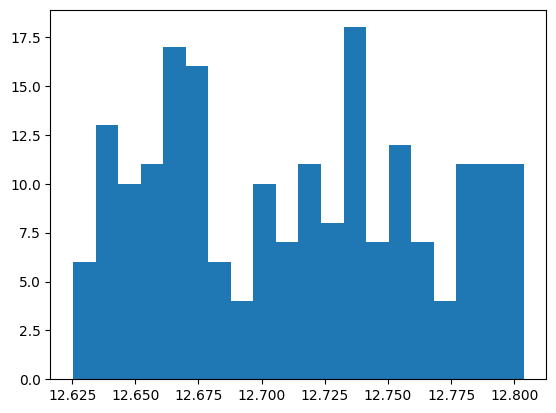

In [60]:
plt.hist(annualized_returns, bins=20)
plt.show()

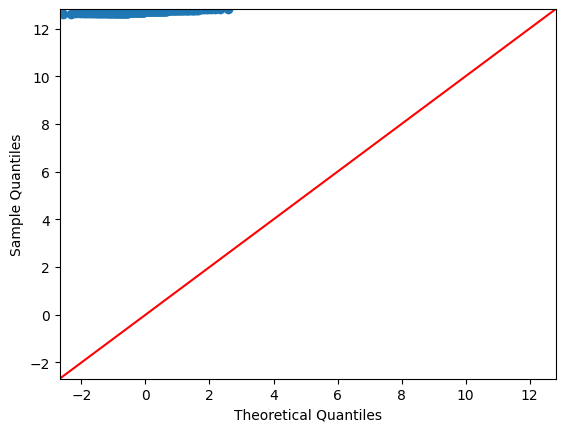

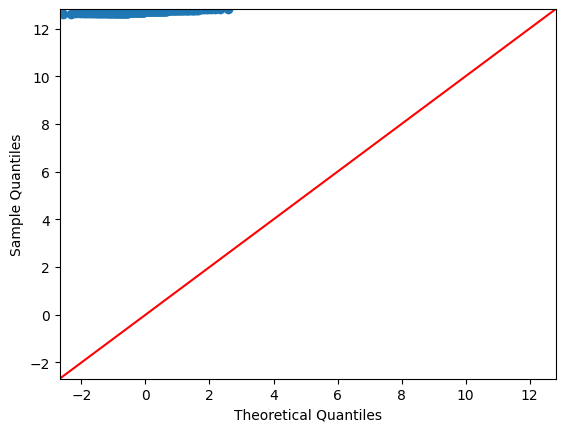

In [61]:
sm.qqplot(np.array(annualized_returns), line ='45')

((array([3.46573590e-03, 8.43263005e-03, 1.34784950e-02, 1.85499498e-02,
         2.36472554e-02, 2.87706768e-02, 3.39204828e-02, 3.90969467e-02,
         4.43003458e-02, 4.95309620e-02, 5.47890815e-02, 6.00749950e-02,
         6.53889979e-02, 7.07313904e-02, 7.61024774e-02, 8.15025688e-02,
         8.69319796e-02, 9.23910299e-02, 9.78800451e-02, 1.03399356e-01,
         1.08949299e-01, 1.14530215e-01, 1.20142454e-01, 1.25786367e-01,
         1.31462315e-01, 1.37170663e-01, 1.42911784e-01, 1.48686055e-01,
         1.54493863e-01, 1.60335598e-01, 1.66211659e-01, 1.72122454e-01,
         1.78068393e-01, 1.84049898e-01, 1.90067397e-01, 1.96121326e-01,
         2.02212127e-01, 2.08340255e-01, 2.14506168e-01, 2.20710335e-01,
         2.26953235e-01, 2.33235353e-01, 2.39557186e-01, 2.45919238e-01,
         2.52322026e-01, 2.58766074e-01, 2.65251917e-01, 2.71780101e-01,
         2.78351183e-01, 2.84965729e-01, 2.91624319e-01, 2.98327543e-01,
         3.05076004e-01, 3.11870316e-01, 3.18711107

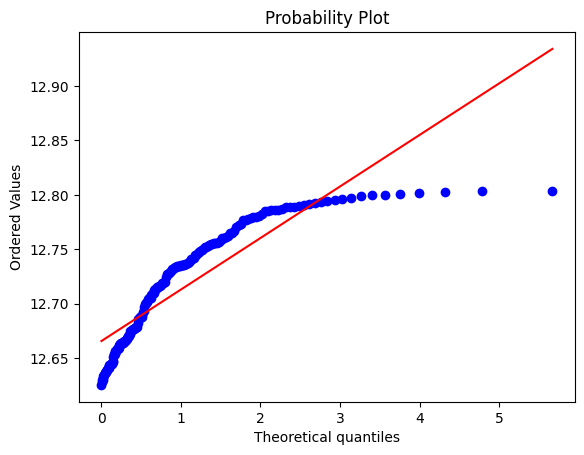

In [62]:
import scipy
scipy.stats.probplot(annualized_returns, dist="expon", plot=plt)